In [1]:
import cv2 as cv
import sys 

import sklearn
import numpy as np 
import os
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.datasets import fetch_openml
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.utils import io

In [42]:
SIZE = 32
VERBOSE = 1000

# Playing with an image!

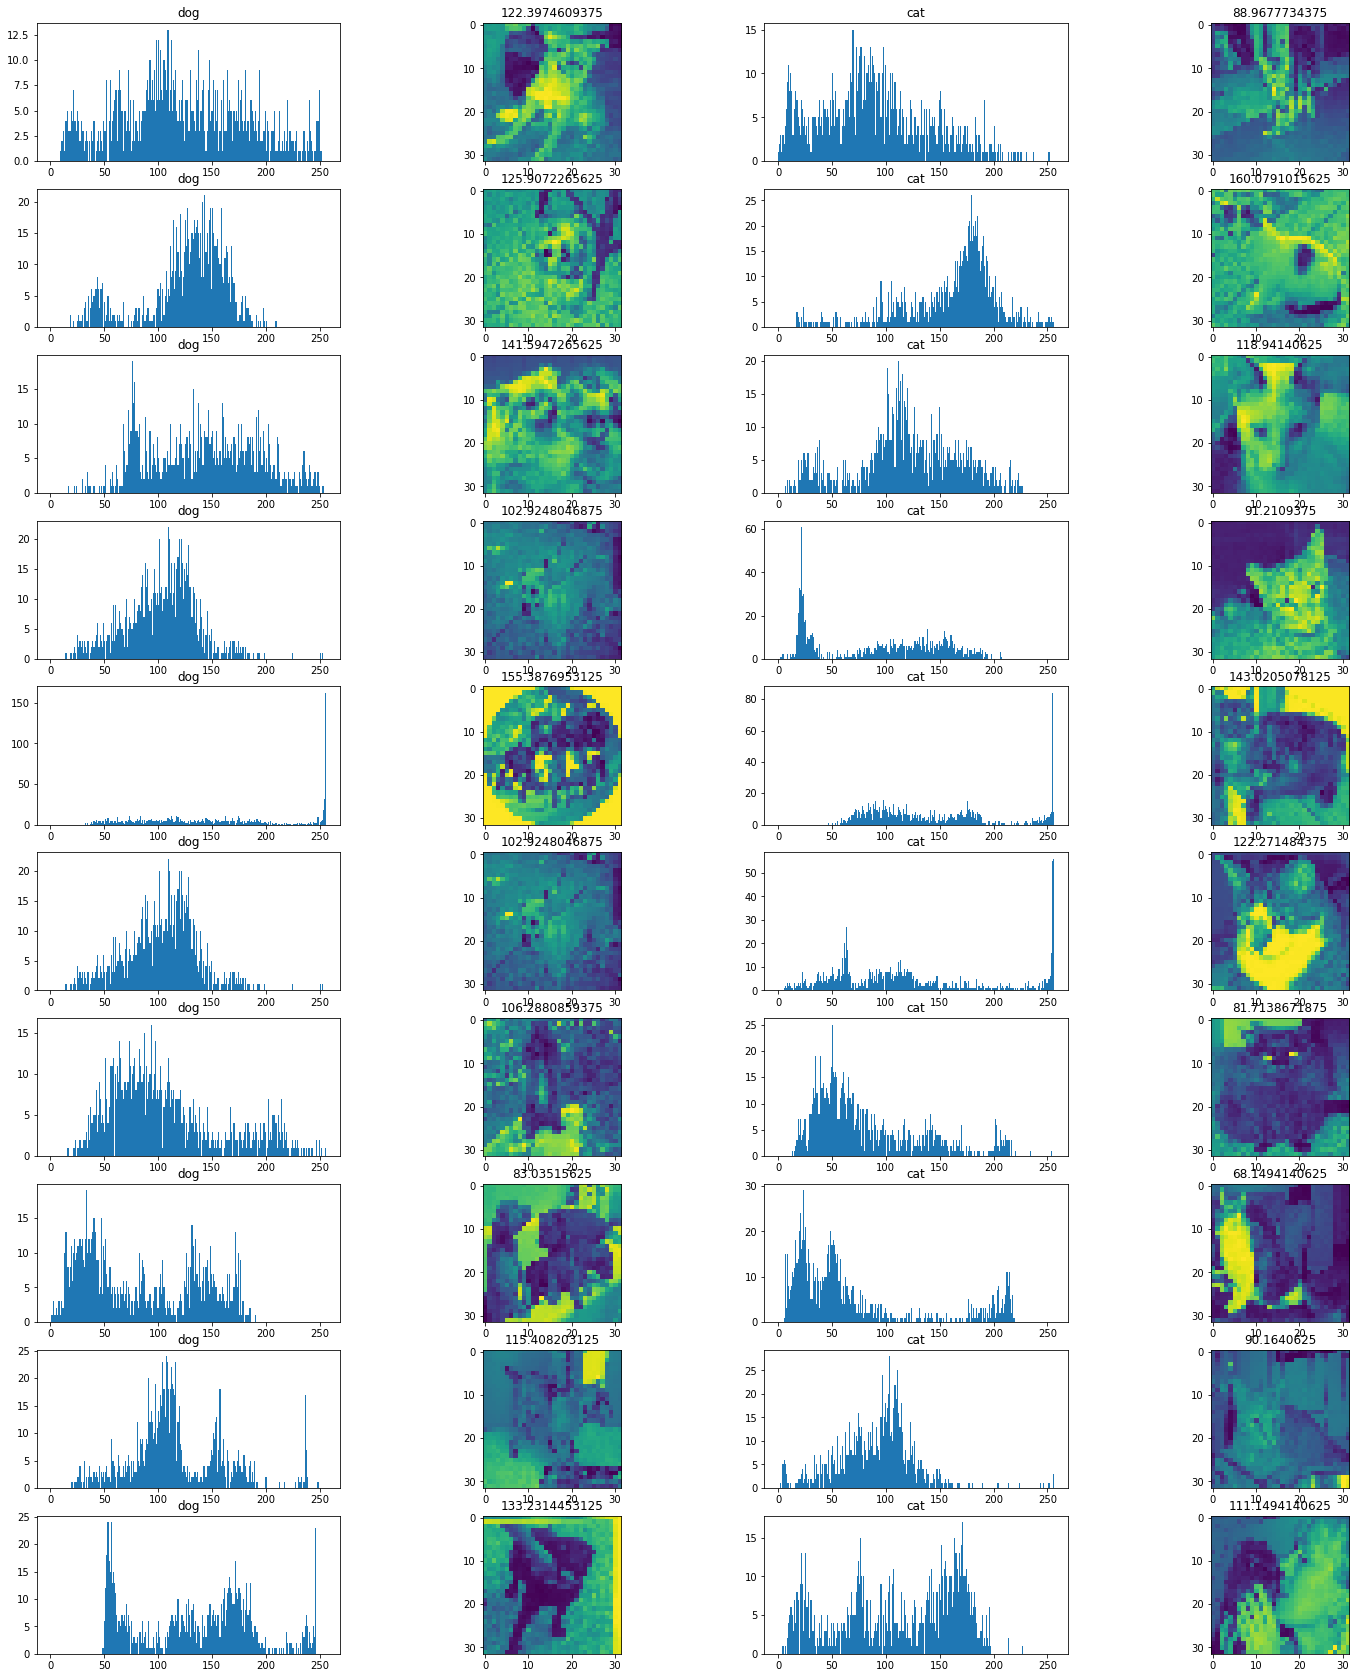

In [3]:
img = cv.imread('data/Cats and dogs/train/dog.10.jpg',0 )
img = cv.resize(img , (SIZE,SIZE))
# ret, thresh1 = cv.threshold(cv.cvtColor(img,cv.COLOR_BGR2GRAY), 120, 255, cv.THRESH_TOZERO_INV + cv.THRESH_BINARY)     
# print(thresh1[0][74])

# for x in range(SIZE):
#     for y in range(SIZE):
#         if thresh1[x][y]==0:
#             img[x][y]=0

# find frequency of pixels in range 0-255
histr = cv.calcHist([img],[0],None,[256],[0,256])

plt.figure(figsize=(25,30))
i = 1
for x in range(1,40 ,4):
    plt.subplot(10,4,x)
    img = cv.imread('data/Cats and dogs/train/dog.{}.jpg'.format(np.random.randint(1,100)),0 )
    img = cv.resize(img , (SIZE,SIZE))
    plt.hist(img.ravel(),256,[0,256])
    plt.title("dog")

    plt.subplot(10,4,x+ 1)
    plt.title(img.ravel().mean())
    plt.imshow(img)

    plt.subplot(10,4,x + 2)
    img = cv.imread('data/Cats and dogs/train/cat.{}.jpg'.format(np.random.randint(1,100)),0 )
    img = cv.resize(img , (SIZE,SIZE))
    plt.hist(img.ravel(),256,[0,256])
    plt.title("cat")

    plt.subplot(10,4,x+ 3)
    plt.title(img.ravel().mean())
    plt.imshow(img)

plt.show()

In [4]:
def procces_image(img_path):
    img = cv.imread(img_path  )
    img = cv.resize(img , (SIZE,SIZE))

    img = img.reshape(SIZE*SIZE*3)
    #img = np.append(img,img.ravel().mean())
    return img

In [5]:
def load_data(path):
    x = []
    y = []

    for file in os.listdir(path):
        label = file.split('.')[-3]
        data = procces_image("{}/{}".format(path,file))
        x.append(data)
        y.append(label)
    return x,y

In [6]:
X,Y = load_data('data/Cats and dogs/train')

In [7]:
X = np.asarray(X)
Y = np.asarray(Y)

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_validate,y_train,y_validate = train_test_split(X,Y ,random_state=42)

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

preprocess = Pipeline([
    ('scaler',StandardScaler()),
    ('pca',PCA(n_components=0.95))],
    verbose=VERBOSE
)

In [10]:
x_reduced = preprocess.fit_transform(x_train)
x_validate_reduced = preprocess.transform(x_validate)

In [34]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(eta=0.15,max_depth=5,eval_metric='mlogloss')
# xgb_clf.fit(x_reduced,y_train)
# xgb_clf.score(x_validate_reduced,y_validate)

In [27]:
from sklearn.naive_bayes import GaussianNB


gnb_clf =  GaussianNB()

gnb_clf.fit(x_reduced,y_train)
gnb_clf.score(x_validate_reduced,y_validate)

0.5872

In [11]:
from sklearn.neighbors import KNeighborsClassifier


knn_clf =  KNeighborsClassifier(n_neighbors=70,weights='distance',n_jobs=-1)

knn_clf.fit(x_reduced,y_train)
knn_clf.score(x_validate_reduced,y_validate)


0.62416

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
#629
ada_clf =  AdaBoostClassifier(DecisionTreeClassifier(max_depth=3),n_estimators=250,learning_rate=0.2)

#ada_clf.fit(x_reduced,y_train)
#ada_clf.score(x_validate_reduced,y_validate)

In [46]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=VERBOSE)

rf_clf.fit(x_reduced,y_train)
rf_clf.score(x_validate_reduced,y_validate)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s

building tree 14 of 100[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s

building tree 15 of 100[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    0.6s

building tree 16 of 100[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    0.7s

building tree 17 of 100[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    0.7s

building tree 18 of 100[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.7s

building tree 19 of 100[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    0.7s
building tree 20 of 100
[Parallel(n_jo

0.61664

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
#629
ada_gb_clf =  AdaBoostClassifier(GaussianNB(),n_estimators=250,learning_rate=0.2)

#ada_gb_clf.fit(x_reduced,y_train)
#ada_gb_clf.score(x_validate_reduced,y_validate)

In [37]:
from sklearn.ensemble import VotingClassifier
#6464
voting_clf = VotingClassifier(
    estimators=[('ada',ada_clf),    
                ('knn',knn_clf),
                ('xgb',xgb_clf)],
            voting='soft',
            weights=[1,1,2],
            verbose=VERBOSE
)
voting_clf.fit(x_reduced, y_train)
voting_clf.score(x_validate_reduced,y_validate)

[Voting] ...................... (1 of 3) Processing ada, total=15.4min
[Voting] ...................... (2 of 3) Processing knn, total=   0.0s
[Voting] ...................... (3 of 3) Processing xgb, total=  27.6s


0.65696

In [48]:
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators=[#('ada',ada_clf),    
                #('knn',knn_clf),
                ('rf',rf_clf),
                ('xgb',xgb_clf),],
                final_estimator=xgb_clf,
                verbose=VERBOSE
)

#stacking_clf.fit(x_reduced,y_train)
#voting_clf.score(x_validate_reduced,y_validate)

In [49]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(stacking_clf,n_jobs=-1,verbose=VERBOSE)
bag_clf.fit(x_reduced,y_train)
bag_clf.score(x_validate_reduced,y_validate)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed: 26.9min
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed: 27.0min remaining: 107.8min
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed: 27.0min remaining: 62.9min
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed: 27.0min remaining: 40.5min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed: 27.1min remaining: 27.1min
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed: 27.1min remaining: 18.1min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed: 27.1min remaining: 11.6min
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed: 27.1min remaining:  6.8min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 27.1min remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed: 27.1min finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:    0.4s
[P

0.66592